<a href="https://colab.research.google.com/github/7-taisei/Road-Accident-Risk-Prediction/blob/main/Predicting_Road_Accident_Risk_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Suppress warnings displayed when using deprecated functions in Python libraries
import warnings
warnings.filterwarnings('ignore')
#Make terminal output visually appealing and easy to use
from rich.console import Console
from rich.table import Table
#Style settings for changing the appearance of graphs in Python's Matplotlib library
plt.style.use("ggplot")

sns.set(font_scale=1.1)

# Load Data

In [56]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [57]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


## Output the characteristics of the dataset in tabular format


In [58]:
#In addition to summary statistics for numerical data in Pandas DataFrames, calculate and clearly display skewness and kurtosis.
def custom_describe(df,categorical=False):
  if not categorical:
    #Extract only the columns with numeric data types from the df, and overwrite the result back into the variable df.
    df=df.select_dtypes(include=np.number)
    #Calculate the basic statistics for each numerical column in df and transpose them. Round the calculation results to two decimal places and store this data in des.
    des=df.describe().T.round(2)
    #The count column in des is a decimal due to describe(), so convert it to an integer.
    des['count']=des['count'].astype(int)
    #Calculate the skewness of each numerical series and add a column named “skewness”.
    des['skewness']=df.skew().round(2)
    #Calculate the kurtosis for each numerical series and add a column named “kurtosis”.
    des['kurtosis']=df.kurtosis().round(2)
  return des

In [59]:
def df_summary(df, label="Train"):
    #Prepare to use the rich library's features.
    console = Console()
    #Displays a visually appealing title with a dividing line.
    console.rule(f"[bold blue]{label} DataFrame Description[/bold blue]")
    #Displays the shape of the DataFrame (number of rows, number of columns).
    console.print(f"[bold]Shape:[/bold] {df.shape}\n")

    # Numeric summary
    # Automatically selects only the numeric columns from the DataFrame.
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        console.print("[bold blue]Numerical Columns:[/bold blue]")
        # Use the `custom_describe` function to calculate detailed statistics such as mean, standard deviation, skewness, and kurtosis.
        num_stats = custom_describe(df[numeric_cols], categorical=False)
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Column")
        #Add the calculated statistics to the table one row at a time.
        for col in num_stats.columns:
            table.add_column(col)
        for idx, row in num_stats.iterrows():
            table.add_row(idx, *[f"{val:.2f}" if isinstance(val, (float, np.float64)) else str(val) for val in row])
        console.print(table)
        console.print("\n")

    # Categorical summary
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        console.print("[bold blue]Categorical Columns:[/bold blue]")
        cat_stats = df[cat_cols].describe().T
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Column")
        for col in cat_stats.columns:
            table.add_column(col)
        for idx, row in cat_stats.iterrows():
            table.add_row(idx, *[str(val) for val in row])
        console.print(table)
        console.print("\n")

df_summary(train)
df_summary(test, "Test")

─────────────────────────────────────────── Train DataFrame Description ───────────────────────────────────────────

Shape: (517754, 13)

Numerical Columns:

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Column                ┃ count     ┃ mean  ┃ std   ┃ min   ┃ 25%   ┃ 50%   ┃ 75%   ┃ max   ┃ skewness ┃ kurtosis ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ num_lanes             │ 517754.00 │ 2.49  │ 1.12  │ 1.00  │ 1.00  │ 2.00  │ 3.00  │ 4.00  │ 0.01     │ -1.37    │
│ curvature             │ 517754.00 │ 0.49  │ 0.27  │ 0.00  │ 0.26  │ 0.51  │ 0.71  │ 1.00  │ -0.04    │ -1.10    │
│ speed_limit           │ 517754.00 │ 46.11 │ 15.79 │ 25.00 │ 35.00 │ 45.00 │ 60.00 │ 70.00 │ 0.18     │ -1.31    │
│ num_reported_acciden… │ 517754.00 │ 1.19  │ 0.90  │ 0.00  │ 1.00  │ 1.00  │ 2.00  │ 7.00  │ 0.37     │ -0.32    │
│ accident_risk         │ 517754.00 │ 0.35  │ 0.17  │ 0.00  │ 0.23  │ 0.34  │ 0.46  │ 1.00  │ 0.38     │ -0.08    │
└───────────────────────┴───────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴──────────┴──────────┘

Categorical Columns:

┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃ Column      ┃ count  ┃ unique ┃ top     ┃ freq   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ road_type   │ 517754 │ 3      │ highway │ 173672 │
│ lighting    │ 517754 │ 3      │ dim     │ 183826 │
│ weather     │ 517754 │ 3      │ foggy   │ 181463 │
│ time_of_day │ 517754 │ 3      │ morning │ 173410 │
└─────────────┴────────┴────────┴─────────┴────────┘

─────────────────────────────────────────── Test DataFrame Description ────────────────────────────────────────────

Shape: (172585, 12)

Numerical Columns:

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Column                ┃ count     ┃ mean  ┃ std   ┃ min   ┃ 25%   ┃ 50%   ┃ 75%   ┃ max   ┃ skewness ┃ kurtosis ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ num_lanes             │ 172585.00 │ 2.49  │ 1.12  │ 1.00  │ 1.00  │ 2.00  │ 3.00  │ 4.00  │ 0.01     │ -1.36    │
│ curvature             │ 172585.00 │ 0.49  │ 0.27  │ 0.00  │ 0.26  │ 0.51  │ 0.71  │ 1.00  │ -0.03    │ -1.10    │
│ speed_limit           │ 172585.00 │ 46.10 │ 15.79 │ 25.00 │ 35.00 │ 45.00 │ 60.00 │ 70.00 │ 0.18     │ -1.31    │
│ num_reported_acciden… │ 172585.00 │ 1.19  │ 0.90  │ 0.00  │ 1.00  │ 1.00  │ 2.00  │ 7.00  │ 0.38     │ -0.31    │
└───────────────────────┴───────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴──────────┴──────────┘

Categorical Columns:

┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Column      ┃ count  ┃ unique ┃ top     ┃ freq  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ road_type   │ 172585 │ 3      │ highway │ 58080 │
│ lighting    │ 172585 │ 3      │ dim     │ 61143 │
│ weather     │ 172585 │ 3      │ foggy   │ 60236 │
│ time_of_day │ 172585 │ 3      │ morning │ 57747 │
└─────────────┴────────┴────────┴─────────┴───────┘

### Q.What's the point of creating such a table? It'll just make EDA easier to understand later.



A.

1.   Quickly identify data issues
2.   Establish data conversion policies
3.   Enhance your understanding with a combination of graphs and figures

I believe the purpose of creating tables of basic statistics is to establish guidelines for subsequent EDA.

Also, visually verify that there are no discrepancies between the training data and test data before performing EDA.

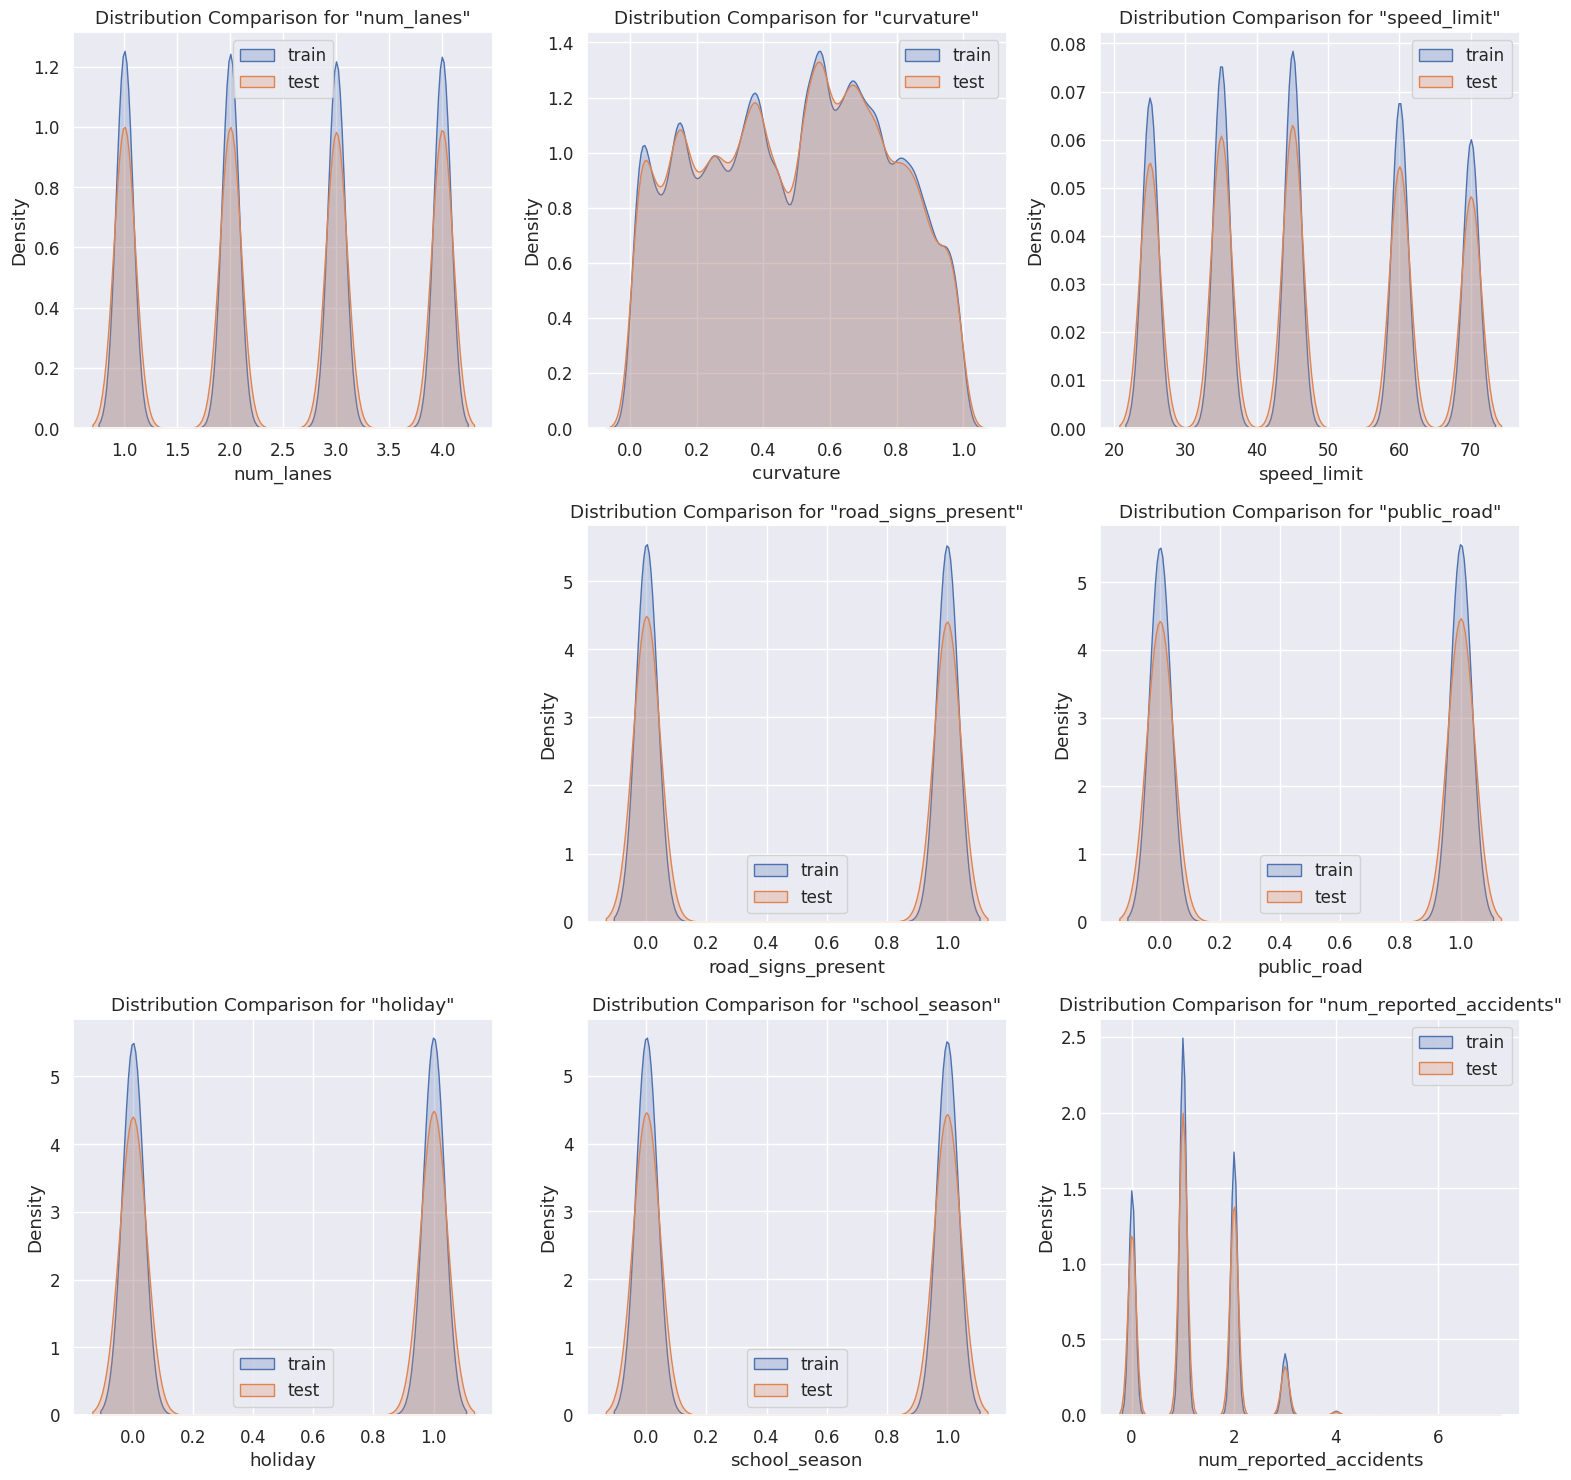

In [60]:
plt.figure(figsize=(20,15))
for i,column in enumerate(train.columns):
  if column in test.columns:
       if pd.api.types.is_numeric_dtype(train[column]):
        plt.subplot(3,4,i+1)
        sns.kdeplot(train[column], label='train', fill=True)
        sns.kdeplot(test[column], label='test', fill=True)
        plt.title(f'Distribution Comparison for "{column}"')
        plt.legend()
plt.tight_layout()
plt.show()

These graphs and tables suggest that there is no significant difference in the overall characteristics of the train and test data.

# EDA

In [61]:
target="accident_risk"

features=test.columns.to_list()
numerical_features=train[features].select_dtypes(include=np.number).columns.to_list()
categorical_features=train[features].select_dtypes(exclude=np.number).columns.to_list()

In [62]:
features

['road_type',
 'num_lanes',
 'curvature',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season',
 'num_reported_accidents']

In [63]:
numerical_features

['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

In [64]:
categorical_features

['road_type',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season']

## 1. Check for missing values,duplicating

In [65]:
train.isnull().sum()

,0
road_type,0
num_lanes,0
curvature,0
speed_limit,0
lighting,0
weather,0
road_signs_present,0
public_road,0
time_of_day,0
holiday,0


In [66]:
#Removing duplicate rows is done to prevent bias and maintain reliability.
num_duplicates=train.duplicated().sum()
print(f"Number of duplicate rows in train: {num_duplicates}")
if num_duplicates > 0:
    train=train.drop_duplicates()

Number of duplicate rows in train: 656


## 2. Univariate Analysis

1. Numerical_feature

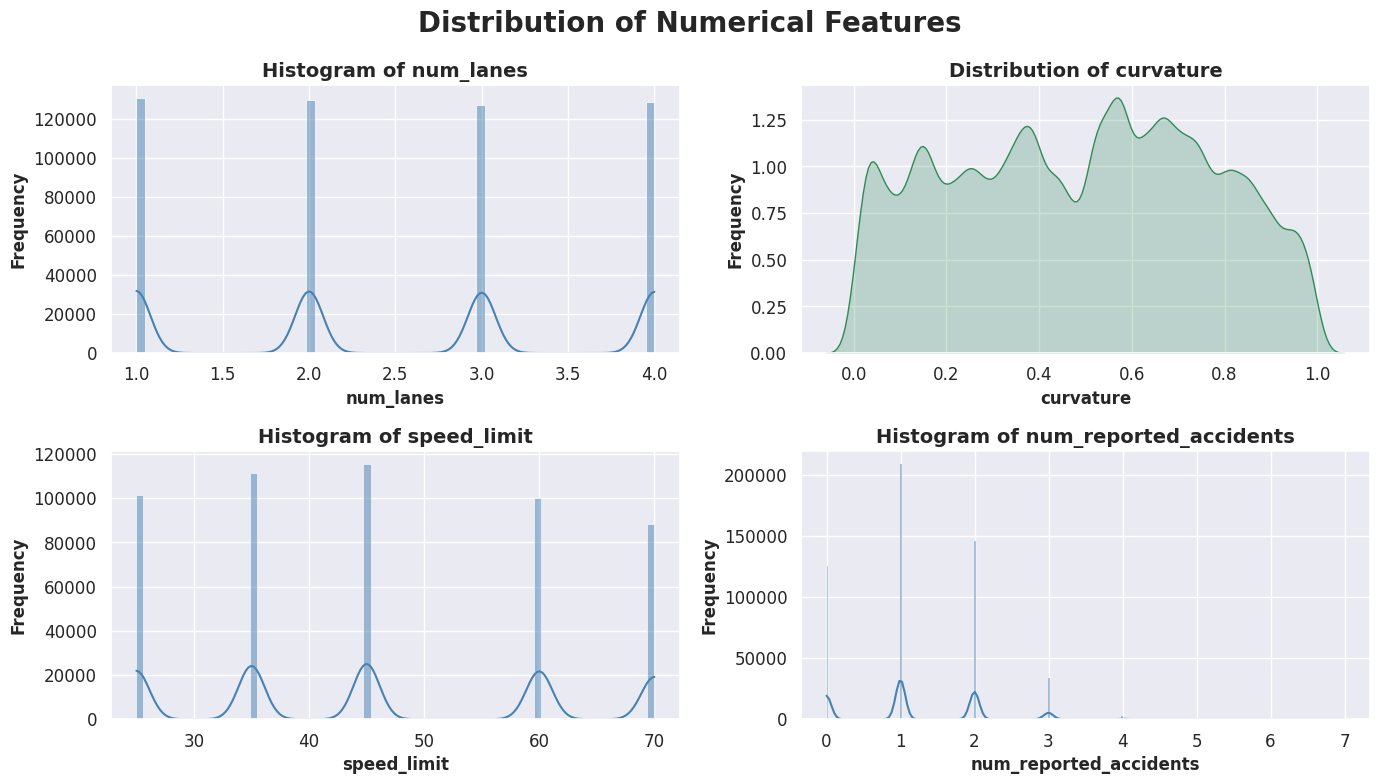

In [67]:
fig, axes=plt.subplots(2,2,figsize=(14,8))
#Converting a two-dimensional array into a one-dimensional array makes it easier to handle with a for loop.
axes=axes.flatten()

for i,feature in enumerate(numerical_features):
  if pd.api.types.is_integer_dtype(train[feature]):
    #Display a kernel density estimation (KDE) curve overlaid on the histogram to smoothly represent the shape of the distribution.
    sns.histplot(data=train,x=feature,ax=axes[i],kde=True,color='steelblue')
    axes[i].set_title(f"Histogram of {feature}",fontweight="bold",fontsize=14)
  else:
    sns.kdeplot(data=train,x=feature,ax=axes[i],fill=True,color='seagreen')
    axes[i].set_title(f"Distribution of {feature}",fontweight="bold",fontsize=14)
  axes[i].set_xlabel(feature,fontsize=12,fontweight="bold")
  axes[i].set_ylabel("Frequency",fontsize=12,fontweight="bold")
plt.suptitle("Distribution of Numerical Features",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

In the three graphs other than num_reported_accident, we can see that the values are equally distributed. However, in num_reported_accident, we can see that the values follow the order 1 > 2 > 3 > 4.

2. Categorical_feature

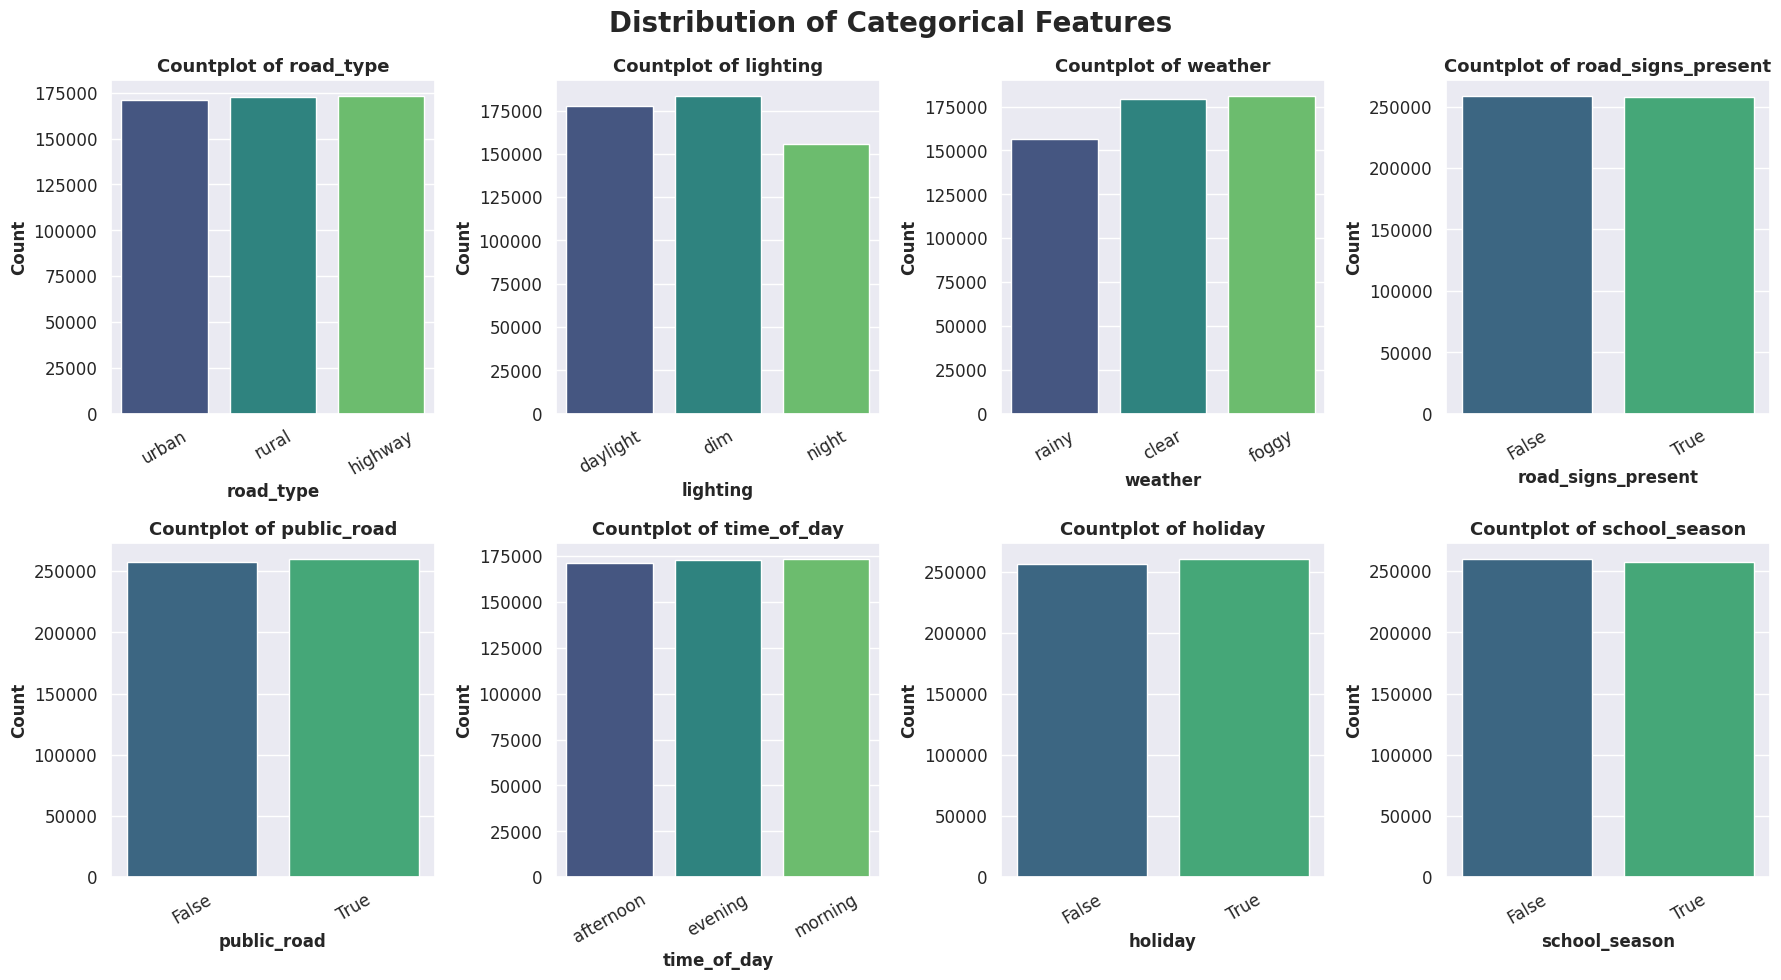

In [68]:
fig, axes=plt.subplots(2,4,figsize=(18,10))
axes=axes.flatten()

for i,feature in enumerate(categorical_features):
  sns.countplot(data=train,x=feature,ax=axes[i],palette='viridis')
  axes[i].set_title(f"Countplot of {feature}",fontweight="bold",fontsize=13)
  axes[i].set_xlabel(feature,fontsize=12,fontweight="bold")
  axes[i].set_ylabel("Count",fontsize=12,fontweight="bold")
  axes[i].tick_params(axis='x',rotation=30)
plt.suptitle("Distribution of Categorical Features",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

From these graphs, it can be seen that the quantities for each category are nearly equal.

## 3. Target Analysis

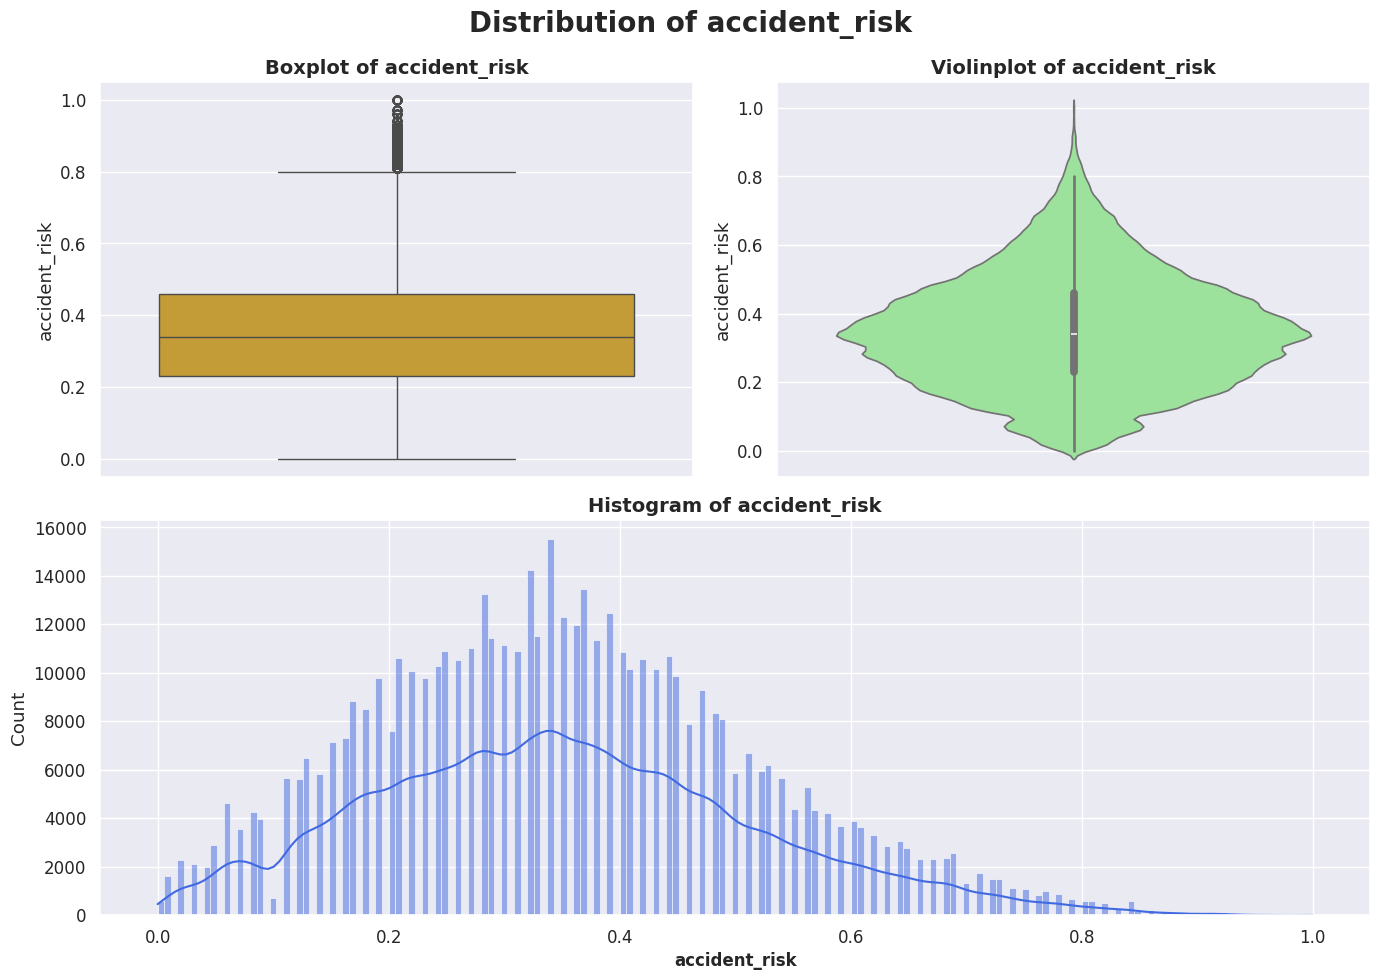

In [69]:
fig,axes=plt.subplot_mosaic([['A','B'],['C','C']],figsize=(14,10))
sns.boxplot(y=target,data=train,ax=axes['A'],color='goldenrod')
axes['A'].set_title(f"Boxplot of {target}",fontweight="bold",fontsize=14)
sns.violinplot(y=target,data=train,ax=axes['B'],color='lightgreen')
axes['B'].set_title(f"Violinplot of {target}",fontweight="bold",fontsize=14)
sns.histplot(train[target],kde=True,ax=axes['C'],color='royalblue')
axes['C'].set_title(f"Histogram of {target}",fontweight="bold",fontsize=14)
axes['C'].set_xlabel(target,fontsize=12,fontweight="bold")
plt.suptitle(f"Distribution of {target}",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

From this, we can see that the target variable accident_risk exhibits a right-skewed distribution.

## Bivariate Analysis

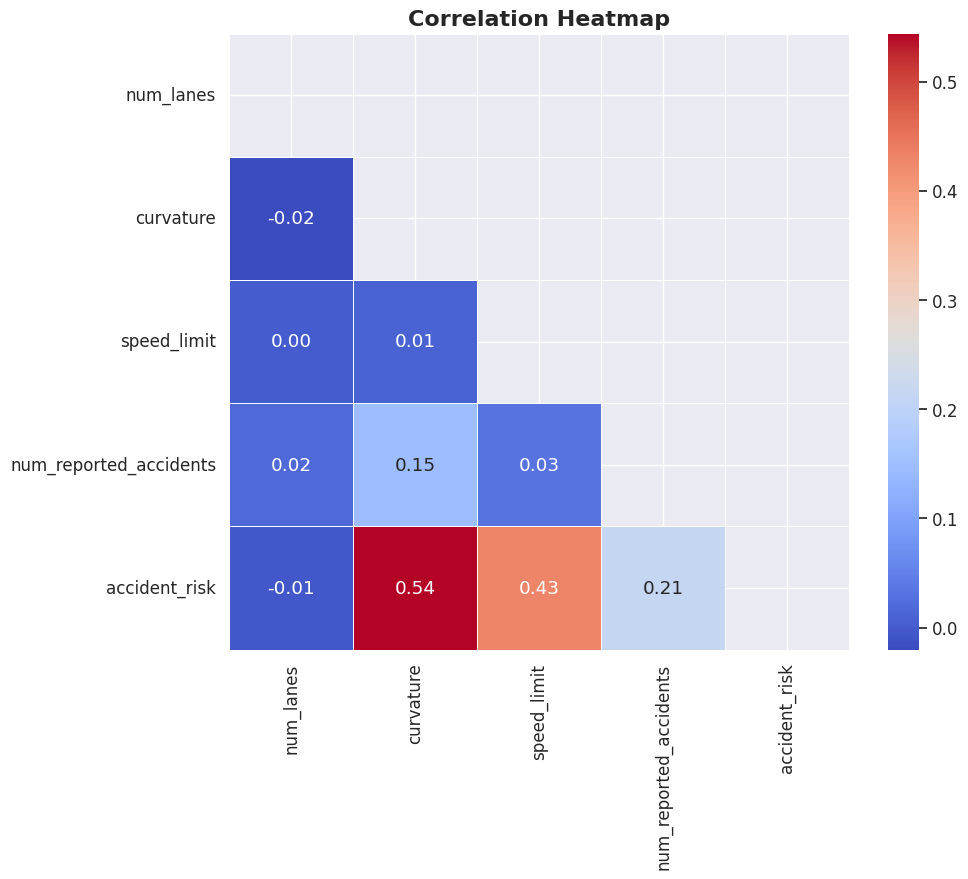

In [70]:
corr=train[numerical_features+[target]].corr()
#This is used to specify “what to display and what to hide” when drawing the heatmap later.
mask=np.triu(np.ones_like(corr,dtype=bool))

plt.figure(figsize=(10,8))
#The top half that is set to True by the mask is hidden.
sns.heatmap(corr,mask=mask,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap",fontweight="bold",fontsize=16)
plt.show()

From this, we can see that the correlation between curvature and speed_limit is relatively high.

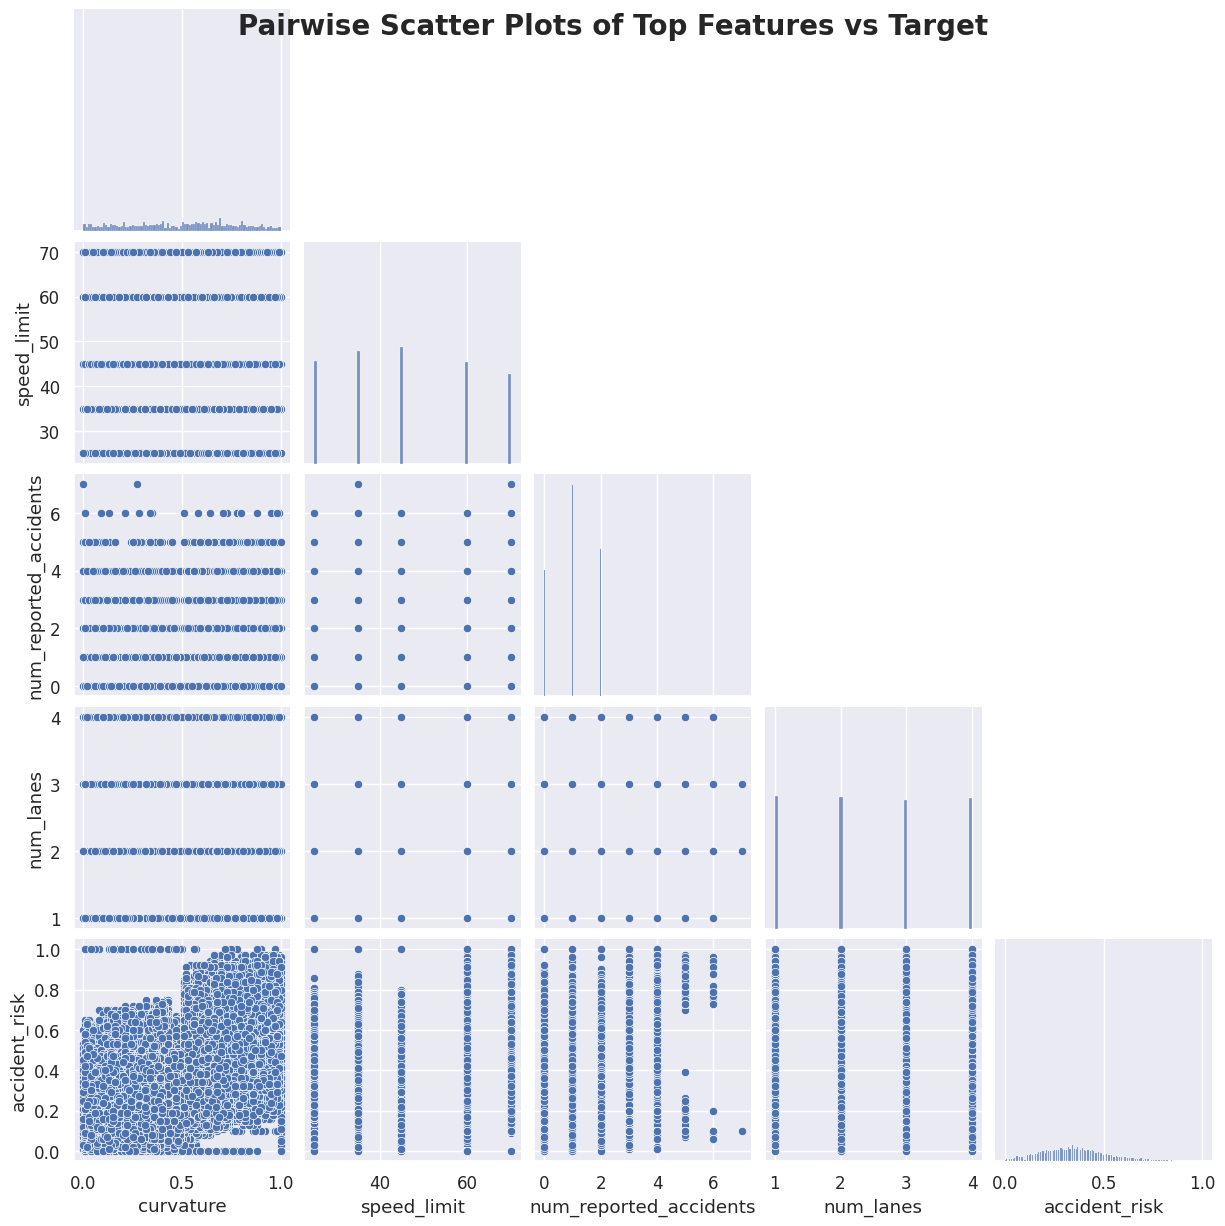

In [71]:
top_corr_features=corr[target].abs().sort_values(ascending=False)[1:5].index.tolist()
sns.pairplot(train,vars=top_corr_features+[target],kind='scatter',corner=True)
plt.suptitle("Pairwise Scatter Plots of Top Features vs Target",fontsize=20,fontweight="bold")
plt.show()

These graphs do not visually show much correlation between the two features.

We consider that accident risk varies depending on road type and lighting.

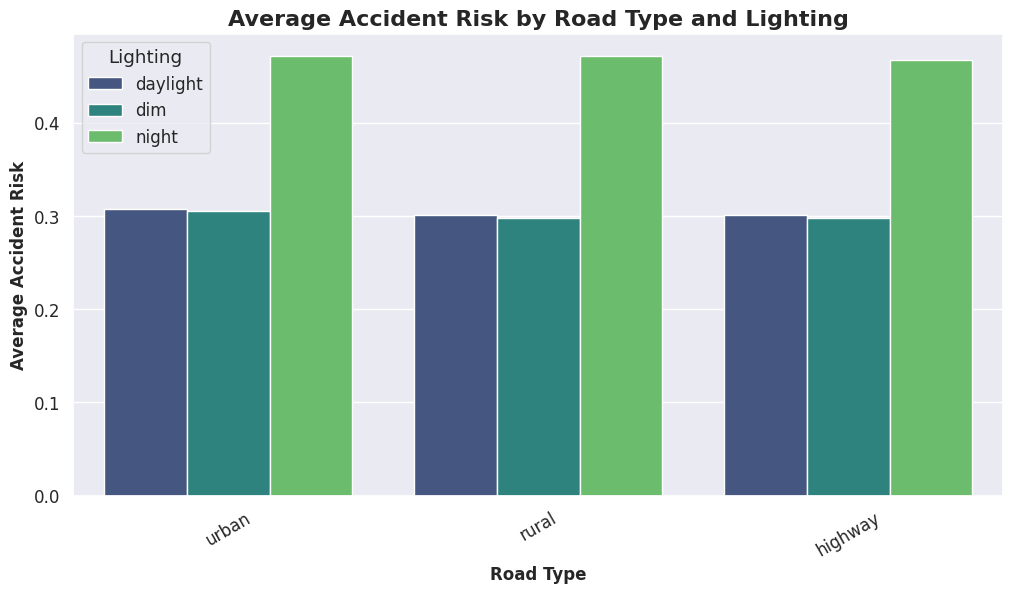

In [72]:
plt.figure(figsize=(12,6))
sns.barplot(x='road_type',y=target,data=train,hue='lighting',ci=None,palette='viridis')
plt.title("Average Accident Risk by Road Type and Lighting",fontweight="bold",fontsize=16)
plt.xlabel("Road Type",fontsize=12,fontweight="bold")
plt.ylabel("Average Accident Risk",fontsize=12,fontweight="bold")
plt.xticks(rotation=30)
plt.legend(title="Lighting")
plt.show()

We believe that accident risk changes depending on holidays and school seasons.

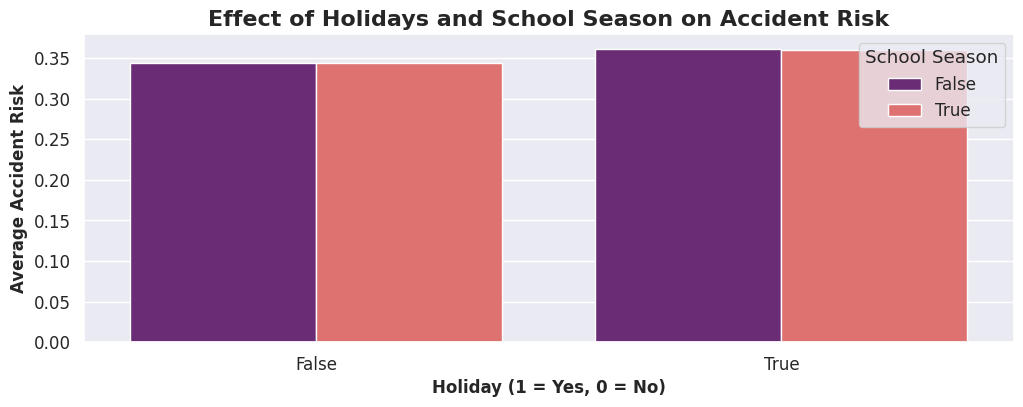

In [73]:
plt.figure(figsize=(12, 4))
sns.barplot(x='holiday', y=target, hue='school_season', data=train, ci=None, palette='magma')
plt.title("Effect of Holidays and School Season on Accident Risk", fontsize=16, fontweight='bold')
plt.xlabel("Holiday (1 = Yes, 0 = No)", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.legend(title="School Season")
plt.show()

We consider that accident risk changes depending on lighting and weather.

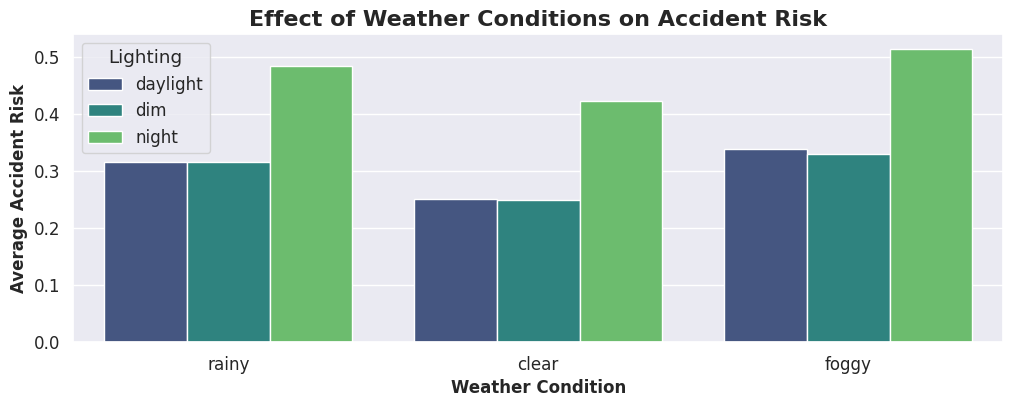

In [74]:
plt.figure(figsize=(12, 4))
sns.barplot(x='weather', y=target, hue='lighting', data=train, ci=None, palette='viridis')
plt.title("Effect of Weather Conditions on Accident Risk", fontsize=16, fontweight='bold')
plt.xlabel("Weather Condition", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.legend(title="Lighting")
plt.show()

We consider that accident risk varies depending on lighting, weather, and time of day.

<Figure size 1600x500 with 0 Axes>

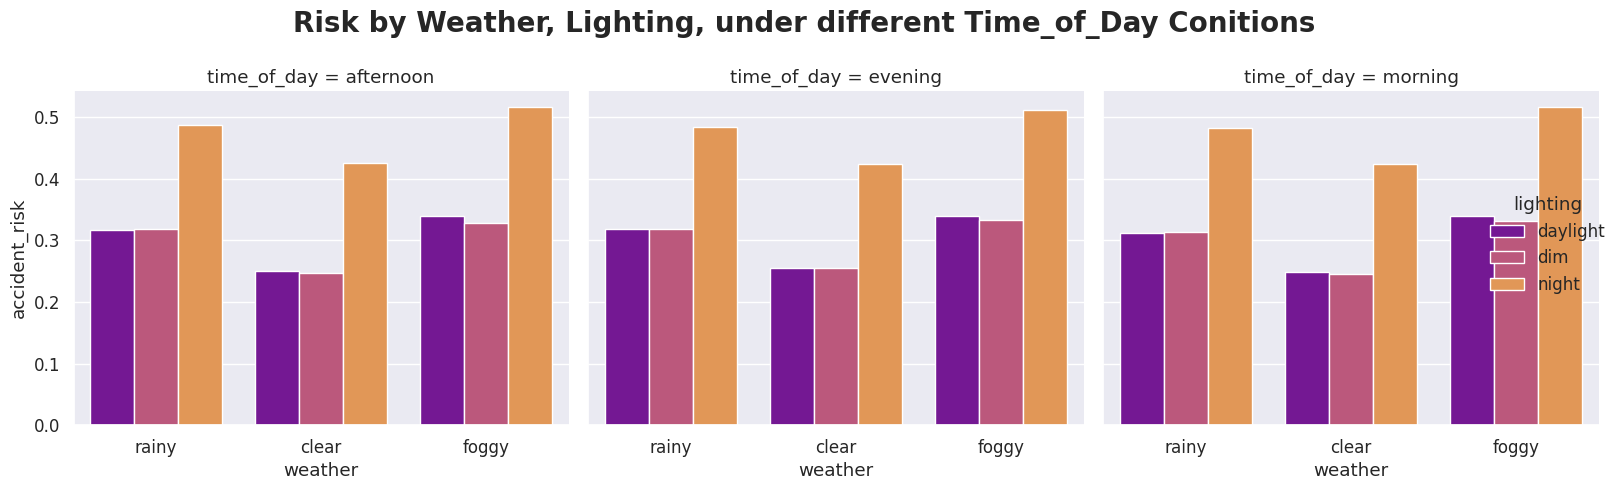

In [75]:
plt.figure(figsize=(16, 5))
sns.catplot(x='weather',y=target,hue='lighting',col='time_of_day',data=train,kind='bar',ci=None,palette='plasma')
plt.suptitle("Risk by Weather, Lighting, under different Time_of_Day Conitions",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

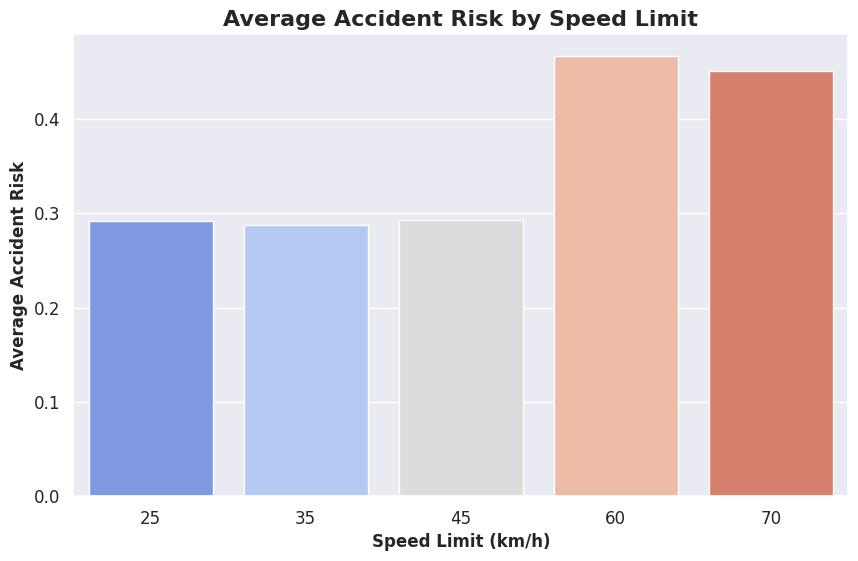

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x='speed_limit', y=target, data=train, ci=None, palette='coolwarm')
plt.title("Average Accident Risk by Speed Limit", fontsize=16, fontweight='bold')
plt.xlabel("Speed Limit (km/h)", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.show()

It can be seen that accident risk increases sharply when the speed limit exceeds 60 km/h.

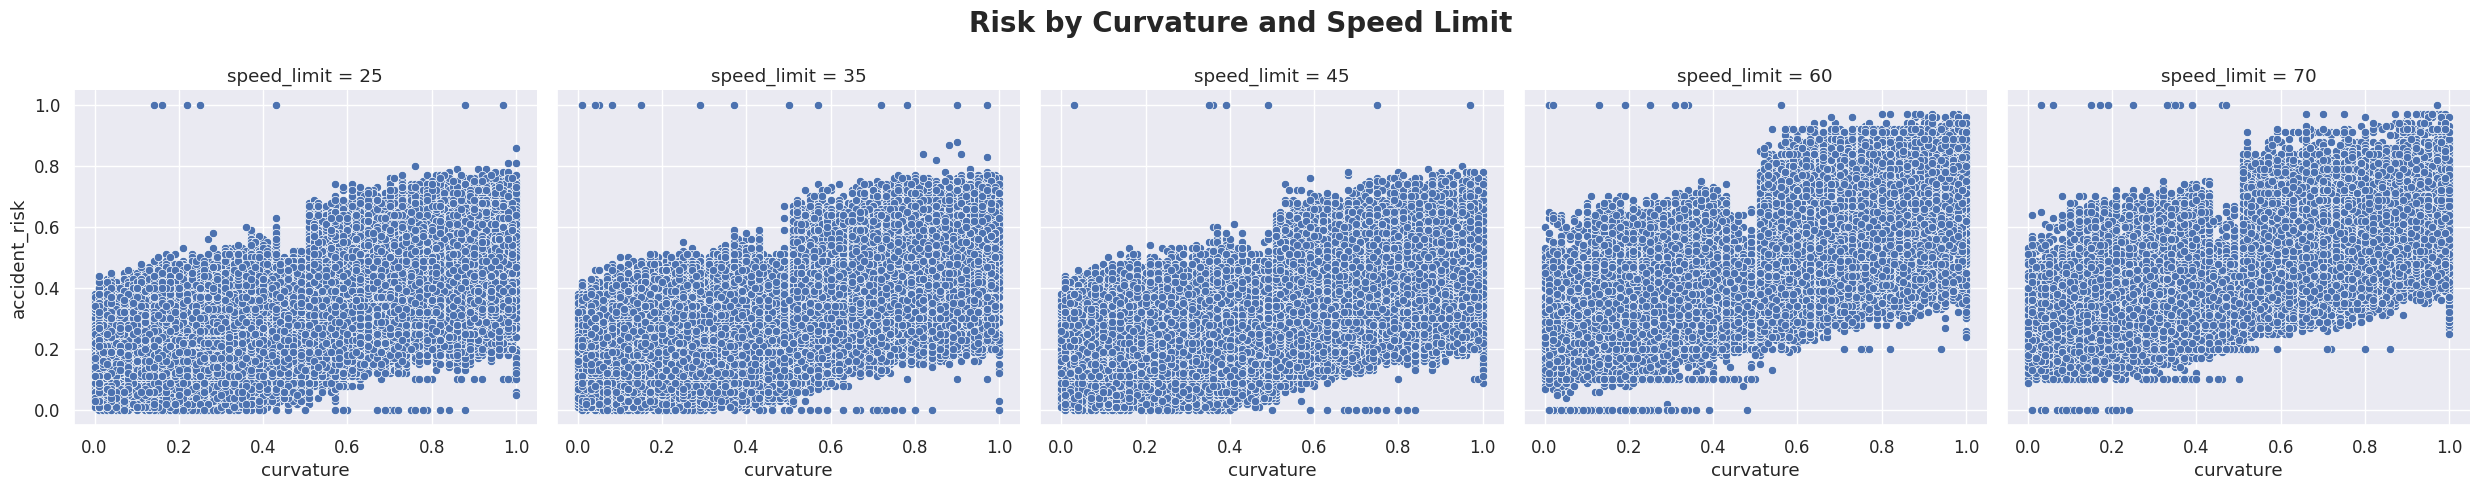

In [77]:
sns.relplot(x='curvature',y=target,col='speed_limit',data=train,kind='scatter',palette='viridis')
plt.suptitle("Risk by Curvature and Speed Limit",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

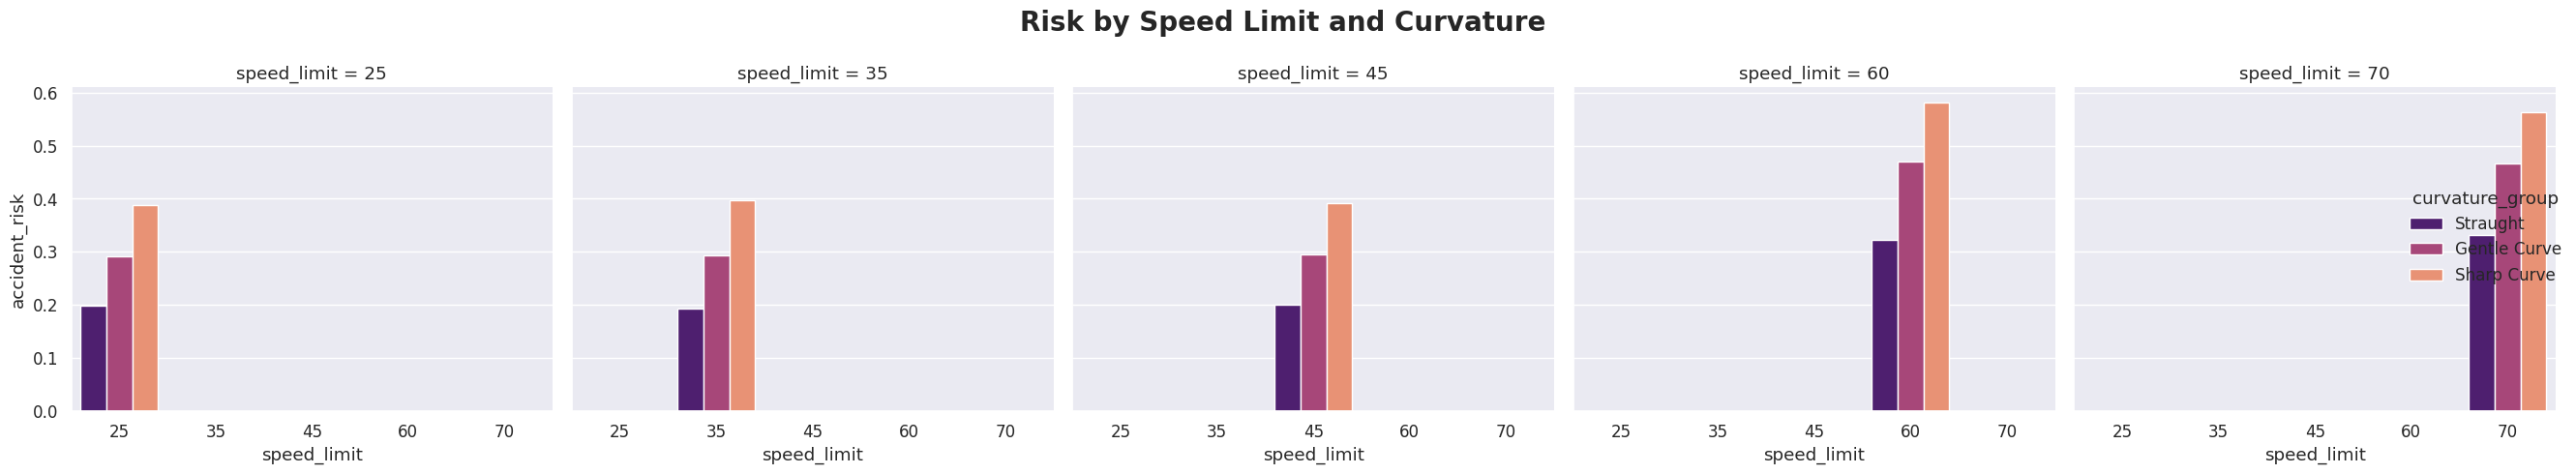

In [78]:
train['curvature_group']=pd.cut(train['curvature'],bins=3,labels=['Straught','Gentle Curve','Sharp Curve'])
sns.catplot(x='speed_limit',y=target,hue='curvature_group',col='speed_limit',data=train,kind='bar',ci=None,palette='magma')
plt.suptitle("Risk by Speed Limit and Curvature",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

As both speed_limit and curvature increase, accident_risk rises.

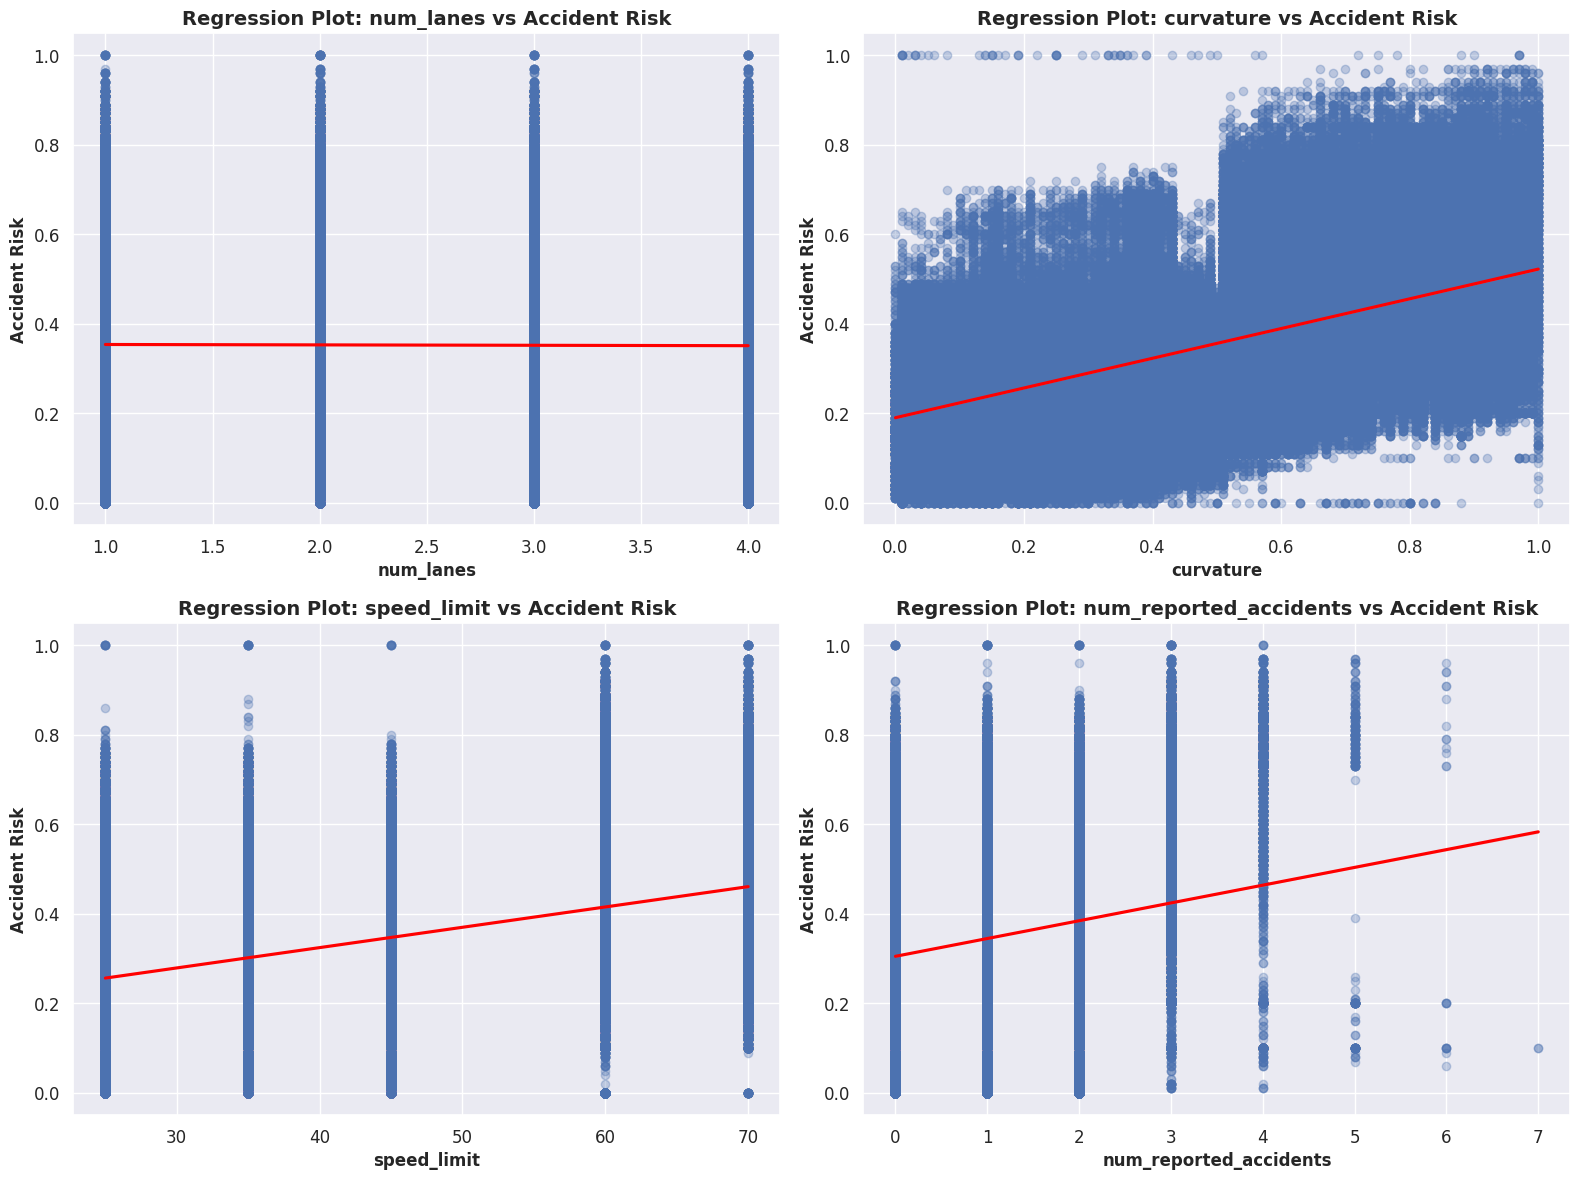

In [79]:
plt.figure(figsize=(16, 12))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=feature, y='accident_risk', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f"Regression Plot: {feature} vs Accident Risk", fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontsize=12, fontweight='bold')
    plt.ylabel("Accident Risk", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Encoding,Scaling

1. One-Hot Encoding

In [95]:
train_encoded=pd.get_dummies(train,columns=['road_type',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'holiday',
 'school_season'],dtype=int,drop_first=True)

In [96]:
train_encoded=train_encoded.drop(columns=['curvature_group'])

time_of_daya is categorical, cyclic features, so using sine and cosine transformations

In [97]:
time_mapping={'morning':0,'afternoon':1,'evening':2,'night':3}
train_encoded['time_of_day']=train_encoded['time_of_day'].map(time_mapping)
cycle_length=3
train_encoded['time_of_day']=np.sin(2*np.pi*train_encoded['time_of_day']/cycle_length)
train_encoded.head()

,num_lanes,curvature,speed_limit,time_of_day,num_reported_accidents,accident_risk,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,road_signs_present_True,public_road_True,holiday_True,school_season_True
id,,,,,,,,,,,,,,,,
0,2,0.06,35,0.866025,1,0.13,0,1,0,0,0,1,0,1,0,1
1,4,0.99,35,-0.866025,0,0.35,0,1,0,0,0,0,1,0,1,1
2,4,0.63,70,0.000000,2,0.30,1,0,1,0,0,0,0,1,1,0
3,4,0.07,35,0.000000,1,0.21,0,0,1,0,0,1,1,1,0,0
4,1,0.58,60,-0.866025,1,0.56,1,0,0,0,1,0,0,0,1,0


Apply standard scaler to numerical features to align their ranges.

In [98]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_encoded[numerical_features]=scaler.fit_transform(train_encoded[numerical_features])
train_encoded.head()

,num_lanes,curvature,speed_limit,time_of_day,num_reported_accidents,accident_risk,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,road_signs_present_True,public_road_True,holiday_True,school_season_True
id,,,,,,,,,,,,,,,,
0,-0.438641,-1.572992,-0.703858,0.866025,-0.209858,0.13,0,1,0,0,0,1,0,1,0,1
1,1.346431,1.838983,-0.703858,-0.866025,-1.325784,0.35,0,1,0,0,0,0,1,0,1,1
2,1.346431,0.518219,1.512905,0.000000,0.906068,0.30,1,0,1,0,0,0,0,1,1,0
3,1.346431,-1.536304,-0.703858,0.000000,-0.209858,0.21,0,0,1,0,0,1,1,1,0,0
4,-1.331176,0.334779,0.879544,-0.866025,-0.209858,0.56,1,0,0,0,1,0,0,0,1,0


In [99]:
df_summary(train_encoded)

─────────────────────────────────────────── Train DataFrame Description ───────────────────────────────────────────

Shape: (517098, 16)

Numerical Columns:

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Column                  ┃ count     ┃ mean  ┃ std  ┃ min   ┃ 25%   ┃ 50%   ┃ 75%  ┃ max  ┃ skewness ┃ kurtosis ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ num_lanes               │ 517098.00 │ 0.00  │ 1.00 │ -1.33 │ -1.33 │ -0.44 │ 0.45 │ 1.35 │ 0.01     │ -1.37    │
│ curvature               │ 517098.00 │ 0.00  │ 1.00 │ -1.79 │ -0.84 │ 0.08  │ 0.81 │ 1.88 │ -0.04    │ -1.10    │
│ speed_limit             │ 517098.00 │ -0.00 │ 1.00 │ -1.34 │ -0.70 │ -0.07 │ 0.88 │ 1.51 │ 0.18     │ -1.31    │
│ time_of_day             │ 517098.00 │ -0.00 │ 0.71 │ -0.87 │ -0.87 │ 0.00  │ 0.87 │ 0.87 │ 0.00     │ -1.50    │
│ num_reported_accidents  │ 517098.00 │ 0.00  │ 1.00 │ -1.33 │ -0.21 │ -0.21 │ 0.91 │ 6.49 │ 0.37     │ -0.32    │
│ accident_risk           │ 517098.00 │ 0.35  │ 0.17 │ 0.00  │ 0.23  │ 0.34  │ 0.46 │ 1.00 │ 0.38     │ -0.08    │
│ road_type_rural         │ 517098.00 │ 0.33  │ 0.47 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.71     │ -1.50    │
│ road_type_urban         │ 517098.00 │ 0.33  │ 0.47 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.72     │ -1.48    │
│ lighting_dim            │ 517098.00 │ 0.36  │ 0.48 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.61     │ -1.63    │
│ lighting_night          │ 517098.00 │ 0.30  │ 0.46 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.87     │ -1.25    │
│ weather_foggy           │ 517098.00 │ 0.35  │ 0.48 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.63     │ -1.61    │
│ weather_rainy           │ 517098.00 │ 0.30  │ 0.46 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.86     │ -1.27    │
│ road_signs_present_True │ 517098.00 │ 0.50  │ 0.50 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.00     │ -2.00    │
│ public_road_True        │ 517098.00 │ 0.50  │ 0.50 │ 0.00  │ 0.00  │ 1.00  │ 1.00 │ 1.00 │ -0.01    │ -2.00    │
│ holiday_True            │ 517098.00 │ 0.50  │ 0.50 │ 0.00  │ 0.00  │ 1.00  │ 1.00 │ 1.00 │ -0.01    │ -2.00    │
│ school_season_True      │ 517098.00 │ 0.50  │ 0.50 │ 0.00  │ 0.00  │ 0.00  │ 1.00 │ 1.00 │ 0.01     │ -2.00    │
└─────────────────────────┴───────────┴───────┴──────┴───────┴───────┴───────┴──────┴──────┴──────────┴──────────┘

# Feature Engineering